In [1]:
from pprint import pprint
import mplfinance as mpf

from tinkoff.invest.utils import quotation_to_decimal

import os

from tinkoff.invest import Client
import logging
import os
from datetime import timedelta
from pathlib import Path

from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.caching.market_data_cache.cache_settings import MarketDataCacheSettings
from tinkoff.invest.services import MarketDataCache
from tinkoff.invest.utils import now
import tinkoff

import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

Загружаем файл c переменными окружения

In [2]:
%load_ext dotenv
%dotenv

In [3]:
TOKEN = os.environ["INVEST_TOKEN"]


client = Client(TOKEN)
client = client.__enter__()


Находим индекс РТС

In [4]:
response = client.instruments.find_instrument(query='сбер')

pprint([i for i in response.instruments if i.instrument_type not in ['futures', 'bond']])

[InstrumentShort(isin='RU0009029540',
                 figi='TCS109029540',
                 ticker='SBER',
                 class_code='SPEQ',
                 instrument_type='share',
                 name='Сбер Банк',
                 uid='5c0ad78f-7188-4846-bdaf-dd1bfd0f0547',
                 position_uid='41eb2102-5333-4713-bf15-72b204c4bf7b',
                 instrument_kind=<InstrumentType.INSTRUMENT_TYPE_SHARE: 2>,
                 api_trade_available_flag=False,
                 for_iis_flag=True,
                 first_1min_candle_date=datetime.datetime(2018, 3, 16, 12, 31, tzinfo=datetime.timezone.utc),
                 first_1day_candle_date=datetime.datetime(2018, 3, 16, 7, 0, tzinfo=datetime.timezone.utc),
                 for_qual_investor_flag=False,
                 weekend_flag=True,
                 blocked_tca_flag=False),
 InstrumentShort(isin='ISSUANCE0180',
                 figi='FAKEFAKE0301',
                 ticker='ISSUANCE0180',
                 class_code=

Загрузим дневные свечи

In [5]:
def get_candles(figi):
    settings = MarketDataCacheSettings(base_cache_dir=Path("../.market_data_cache"))
    market_data_cache = MarketDataCache(settings=settings, services=client)
    candles = list(market_data_cache.get_all_candles(
        figi=figi,
        from_=now() - timedelta(days=375),
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
    ))
    return candles

In [6]:
def get_candles_data(candles):
    candles_data = []
    for candle in candles:
        date = candle.time.date()
        open_ = quotation_to_decimal(candle.open)
        high = quotation_to_decimal(candle.high)
        low = quotation_to_decimal(candle.low)
        close = quotation_to_decimal(candle.close)
        volume = candle.volume
        data = {
            'date': date,
            'open': open_,
            'high': high,
            'low': low,
            'close': close,
            'volume': volume,
        }
        candles_data.append(data)
    return candles_data

In [7]:
def load_plot_candles(figi, stocks_df_csv_path='../stocks_dataframe.csv'):
    candles = get_candles(figi)
    
    instrument = client.instruments.share_by(id=figi, id_type=tinkoff.invest.schemas.InstrumentIdType.INSTRUMENT_ID_TYPE_FIGI).instrument
    name = instrument.name
    
    candles_data = get_candles_data(candles)
    df = pd.DataFrame(data=candles_data)
    df.to_csv(stocks_df_csv_path, index=False)
    df = pd.read_csv(stocks_df_csv_path, index_col=0, parse_dates=True)

    _fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(2, 1, height_ratios=[3, 1])
    _ax1 = plt.subplot(gs[0])
    _ax1.set_title(name)
    _ax2 = plt.subplot(gs[1])
    mpf.plot(data=df, style='charles', type='candle', ax=_ax1, volume=_ax2)

    # mpf.plot(data=df, style='charles', type='candle', volume=True)
    
    return df

,open,high,low,close,volume
date,,,,,
2022-05-04,130.40,132.23,124.28,124.80,347366
2022-05-05,125.34,126.87,125.00,125.47,152732
2022-05-06,125.47,125.47,123.00,124.20,129030
2022-05-11,124.30,126.41,120.90,121.11,580965
2022-05-12,120.00,121.90,115.60,116.60,677157
...,...,...,...,...,...
2023-05-06,235.83,240.93,233.42,237.06,11352
2023-05-07,237.07,239.38,233.16,236.83,10093
2023-05-08,237.00,238.89,235.36,235.97,591848


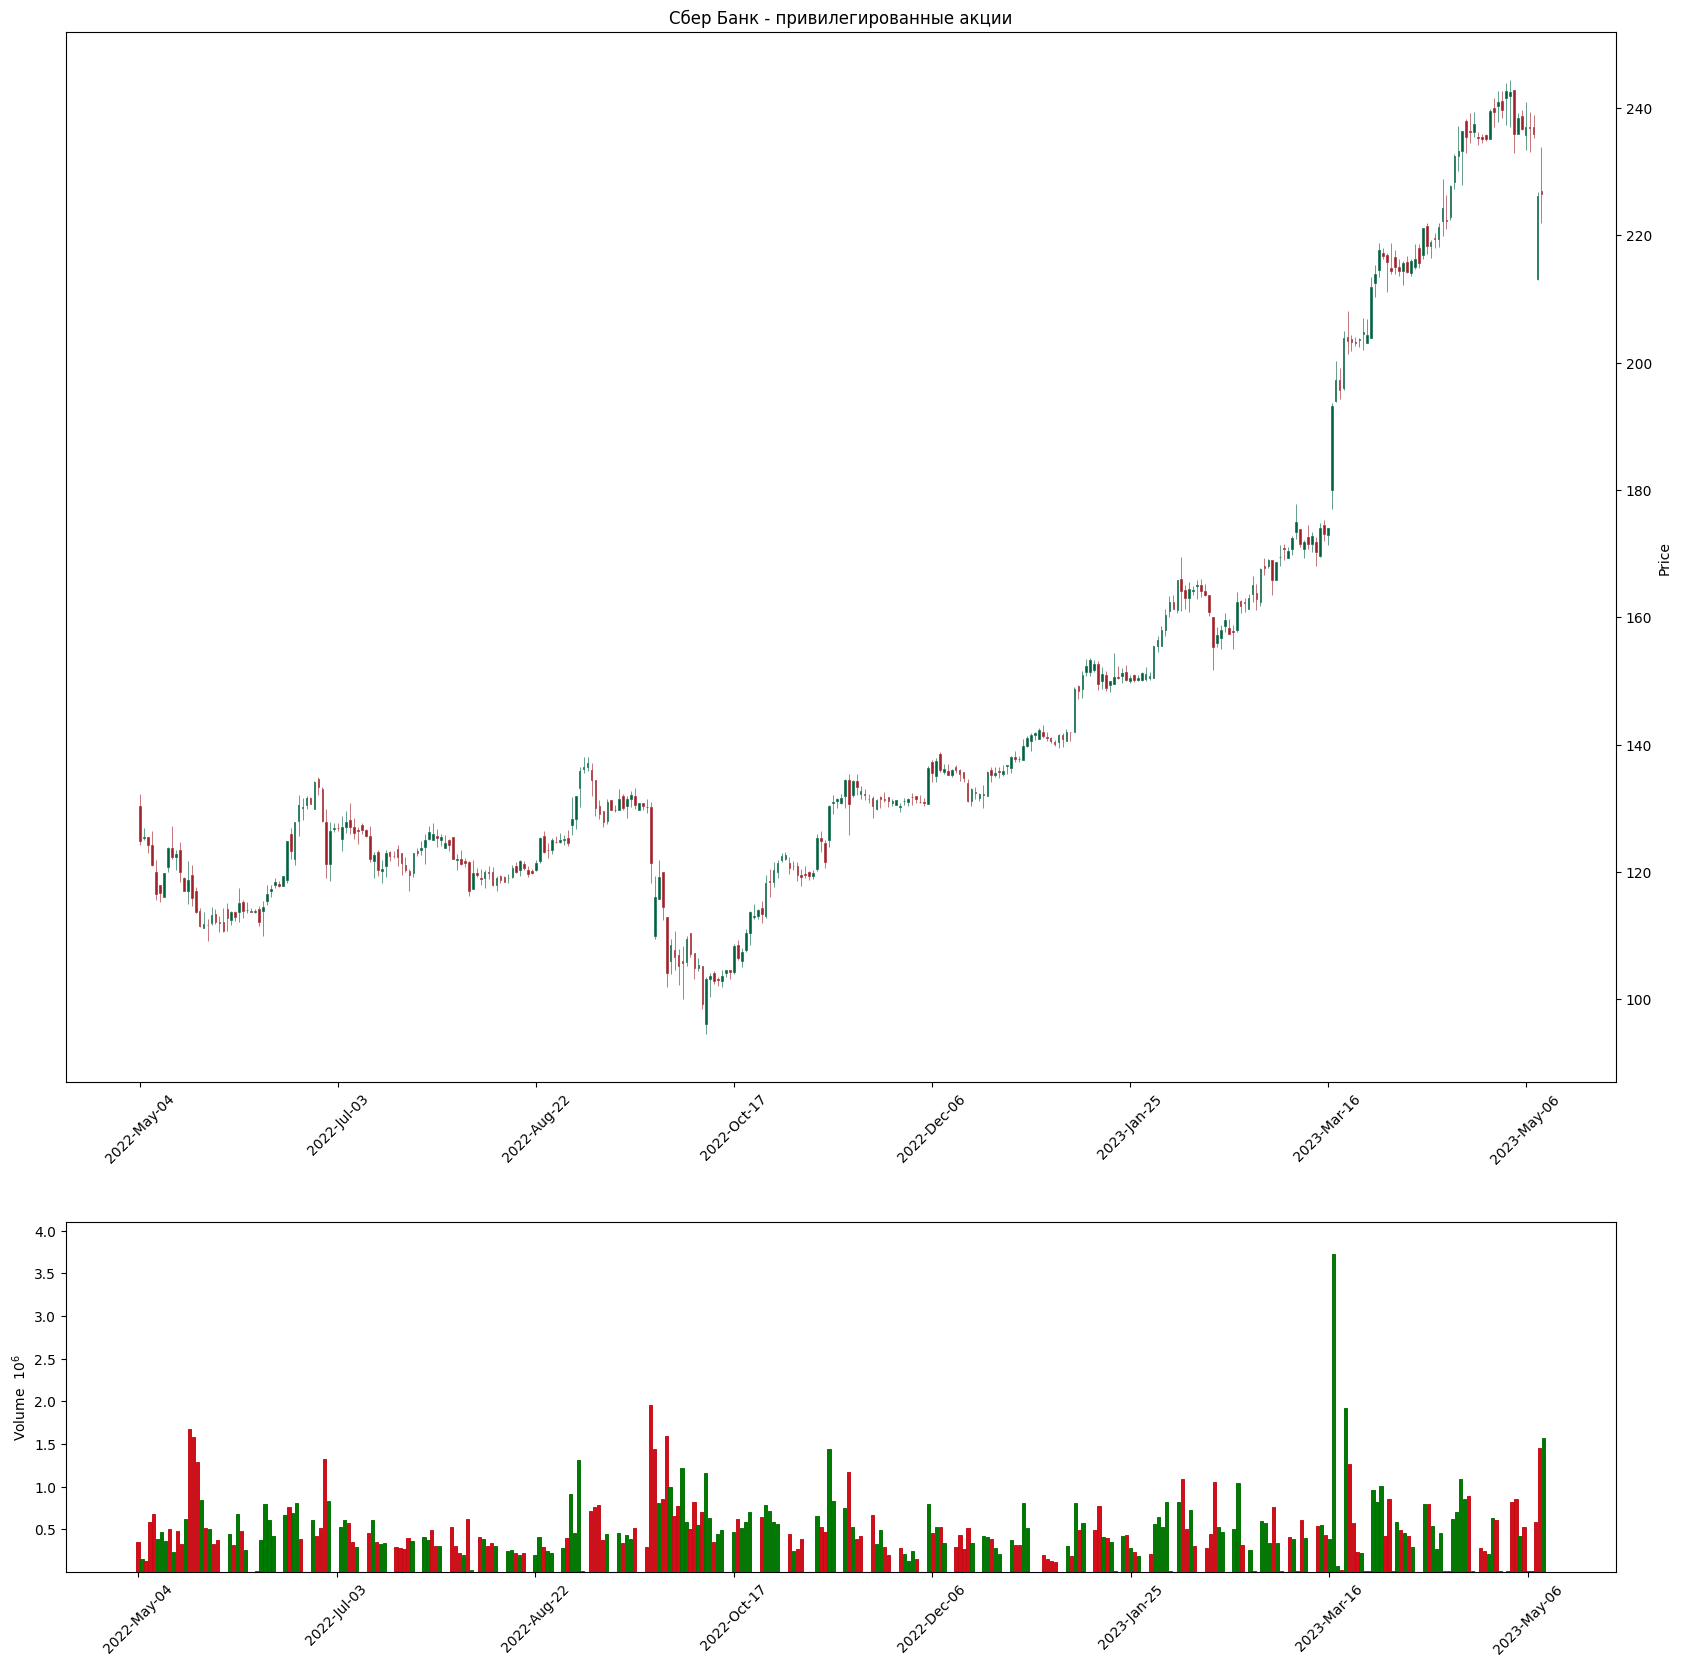

In [8]:
load_plot_candles(figi='BBG0047315Y7')